<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
# !pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import re

import seaborn
seaborn.set(palette='summer')

C:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
C:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
import os
import gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    gc.collect()

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ChernovNK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
nltk.download('punkt_tab') 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ChernovNK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [210]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [7]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [8]:
dataset['train']['text'][100]

"Terrible movie. Nuff Said.<br /><br />These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time. I just wanted to warn others. Avoid this movie. The acting sucks and the writing is just moronic. Bad in every way. The only nice thing about the movie are Deniz Akkaya's breasts. Even that was ruined though by a terrible and unneeded rape scene. The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum. First I waste my time watching this offal. Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is. Totally unnecessary."

In [9]:
sent_tokenize(dataset['train']['text'][100], language='english')

['Terrible movie.',
 'Nuff Said.<br /><br />These Lines are Just Filler.',
 'The movie was bad.',
 "Why I have to expand on that I don't know.",
 'This is already a waste of my time.',
 'I just wanted to warn others.',
 'Avoid this movie.',
 'The acting sucks and the writing is just moronic.',
 'Bad in every way.',
 "The only nice thing about the movie are Deniz Akkaya's breasts.",
 'Even that was ruined though by a terrible and unneeded rape scene.',
 'The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum.',
 'First I waste my time watching this offal.',
 'Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is.',
 'Totally unnecessary.']

In [10]:
len(sent_tokenize(dataset['train']['text'][100], language='english')[0])

15

In [11]:
def clean_text(example):
    text = example['text']
    text = re.sub(r'<.*?>', ' ', text)           # удалить все теги
    text = re.sub(r'\s+', ' ', text).strip()    # убрать лишние пробелы
    return {'text': text}

dataset = dataset.map(clean_text)

In [12]:
sent_tokenize(dataset['train']['text'][100], language='english')

['Terrible movie.',
 'Nuff Said.',
 'These Lines are Just Filler.',
 'The movie was bad.',
 "Why I have to expand on that I don't know.",
 'This is already a waste of my time.',
 'I just wanted to warn others.',
 'Avoid this movie.',
 'The acting sucks and the writing is just moronic.',
 'Bad in every way.',
 "The only nice thing about the movie are Deniz Akkaya's breasts.",
 'Even that was ruined though by a terrible and unneeded rape scene.',
 'The movie is a poorly contrived and totally unbelievable piece of garbage.',
 'OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum.',
 'First I waste my time watching this offal.',
 'Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is.',
 'Totally unnecessary.']

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [14]:
sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold] # re.findall(r'\w+', x)   x.split(' ')
        )
for sentence in tqdm(dataset['test']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
        )
for sentence in tqdm(dataset['unsupervised']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
        )
# Получить отдельные предложения и поместить их в sentences

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:00<00:00, 824.81it/s]


In [15]:
for x in sent_tokenize(sentence, language='english'):
    print(x), print(len(x)), print(x.split(' ')), print(re.findall(r'\w+', x))
    break

I do firmly believe that the revue on this film is highly unfair.
65
['I', 'do', 'firmly', 'believe', 'that', 'the', 'revue', 'on', 'this', 'film', 'is', 'highly', 'unfair.']
['I', 'do', 'firmly', 'believe', 'that', 'the', 'revue', 'on', 'this', 'film', 'is', 'highly', 'unfair']


In [16]:
print("Всего предложений:", len(sentences))

Всего предложений: 1006976


In [17]:
sentences_for_dict = []

for sentence in tqdm(dataset['train']['text']):
    sentences_for_dict.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english')]
        )
for sentence in tqdm(dataset['test']['text']):
    sentences_for_dict.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english')]
        )
for sentence in tqdm(dataset['unsupervised']['text']):
    sentences_for_dict.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english')]
        )

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 3984.85it/s]


In [18]:
print("Всего предложений:", len(sentences_for_dict))

Всего предложений: 1236000


Посчитаем для каждого слова его встречаемость.

In [19]:
import random
sentences[random.randint(0,112679)]

'kali maa in reality is a caring and compassionate mother, whom we shed tears at her beautiful feet in devotion and love for.'

In [20]:
words = Counter()

for sentence in tqdm(sentences_for_dict):
    # tokens = re.findall(r'\w+', sentence.lower())  # выделяем слова без пунктуации
    tokens = word_tokenize(sentence.lower())
    words.update(tokens)

    # for word in sentence.split():
    # words[word] += 1
# Расчет встречаемости слов
# words

100%|█████████████████████████████████████████████████████████████████████| 1236000/1236000 [01:39<00:00, 12438.42it/s]


In [21]:
len(words)

230074

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [22]:
vocab = set()
vocab_size = 80_000

# Наполнение словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])

for word, cnt in words.most_common():
    if len(vocab) >= vocab_size+4:
        break
    vocab.add(word)

In [23]:
# vocab

In [24]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [25]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 80004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [26]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [27]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        # tokens = re.findall(r'\w+', self.data[idx].lower())
        tokens = word_tokenize(self.data[idx].lower())

        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in tokens] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [28]:
dataset = WordDataset(["I love NLP!"])
print(dataset[0])

[44294, 59159, 35522, 6982, 41311, 25361]


In [29]:
ind2word[dataset[0][0]], ind2word[dataset[0][1]], ind2word[dataset[0][2]], ind2word[dataset[0][3]], ind2word[dataset[0][4]], ind2word[dataset[0][5]]

('<bos>', 'i', 'love', '<unk>', '!', '<eos>')

In [30]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [31]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, shuffle=True)
# eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5, shuffle=True)

train_dataset = WordDataset(train_sentences) 
eval_dataset = WordDataset(eval_sentences)
# test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# test_dataloader = DataLoader(
#     test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [32]:
# def evaluate(model, criterion, dataloader) -> float:
#     model.eval()
#     perplexity = []
#     with torch.no_grad():
#         for batch in dataloader:
#             logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
#             loss = criterion(logits, batch['target_ids'].flatten())
#             perplexity.append(torch.exp(loss).item())

#     perplexity = sum(perplexity) / len(perplexity)

#     return perplexity


# Нужно считать экспоненту от средней потери по всем токенам, а не усреднять экспоненты.
# Паддинги нужно исключать, иначе перплексия искусственно занижается (ведь <pad> всегда предсказан с высокой вероятностью, что уменьшает loss).
import math

def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            target_ids = batch['target_ids']

            # Предсказания
            logits = model(input_ids)
            logits = logits.flatten(0, 1)
            targets = target_ids.flatten()

            # criterion сам игнорирует паддинги
            loss = criterion(logits, targets)

            # Суммируем loss * число непадинговых токенов
            # CrossEntropyLoss возвращает средний loss по valid токенам в batch
            nonpad_count = (targets != criterion.ignore_index).sum().item()
            total_loss += loss.item() * nonpad_count
            total_tokens += nonpad_count

    # Средняя потеря по всем valid токенам
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity, avg_loss

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [60]:
import copy
def train_model(model, num_epoch, sched = False, clip = False):

    best_loss = float('inf') 
    best_model_wts = None
    
    # history = dict(train=[], test=[])

    train_raw_losses = []
    eval_token_losses = []
    eval_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            
            if clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()    

            epoch_losses.append(loss.item())

        if sched:
            scheduler.step()
        
        # Train
        mean_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_raw_losses.append(mean_train_loss)
        # Val
        ppl, mean_test_loss = evaluate(model, criterion, eval_dataloader)
        eval_token_losses.append(mean_test_loss)
        eval_perplexities.append(ppl)

        if mean_test_loss < best_loss:
            best_loss = mean_test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        clear_gpu_memory()
    model.load_state_dict(best_model_wts)


    return model, train_raw_losses, eval_token_losses, eval_perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [34]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.15)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [35]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab))
# print(f"available GPUs: {torch.cuda.device_count()}")
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

C:\ProgramData\anaconda3\envs\LLM\Lib\site-packages\torch\nn\modules\module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [36]:
model.eval()
with torch.no_grad():
    for batch in eval_dataloader:
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        break
print(logits, logits.shape)

tensor([[-0.0599,  0.0086,  0.0409,  ..., -0.0506, -0.0293,  0.0353],
        [-0.0443,  0.0711,  0.0968,  ..., -0.1127, -0.0836, -0.0003],
        [ 0.0886, -0.0168,  0.0834,  ..., -0.0307, -0.0741, -0.0238],
        ...,
        [ 0.0213, -0.0623,  0.0077,  ..., -0.0956, -0.1438, -0.0381],
        [ 0.0213, -0.0623,  0.0077,  ..., -0.0956, -0.1437, -0.0380],
        [ 0.0213, -0.0622,  0.0077,  ..., -0.0957, -0.1436, -0.0380]],
       device='cuda:0') torch.Size([4096, 80004])


In [37]:
batch['input_ids'].shape, batch['target_ids'].shape, batch['input_ids'].flatten(0, 1).shape

(torch.Size([128, 32]), torch.Size([128, 32]), torch.Size([4096]))

In [38]:
batch['input_ids'][0] # 35

tensor([44294, 22027, 51045, 54111, 76883,  8021, 12446,  2472, 70798, 21696,
        22922, 76883, 63335, 78529, 69583, 75960, 60090, 67823, 22922, 74487,
        33725, 58380, 25361,  4683,  4683,  4683,  4683,  4683,  4683,  4683,
         4683,  4683], device='cuda:0')

In [39]:
model(batch['input_ids'])[0] # 35 x 40004

tensor([[-0.0599,  0.0086,  0.0409,  ..., -0.0506, -0.0293,  0.0353],
        [-0.0443,  0.0711,  0.0968,  ..., -0.1127, -0.0836, -0.0003],
        [ 0.0886, -0.0168,  0.0834,  ..., -0.0307, -0.0741, -0.0238],
        ...,
        [ 0.0257, -0.0627,  0.0122,  ..., -0.0865, -0.1509, -0.0421],
        [ 0.0241, -0.0629,  0.0099,  ..., -0.0888, -0.1496, -0.0407],
        [ 0.0230, -0.0629,  0.0086,  ..., -0.0905, -0.1484, -0.0399]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [40]:
model(batch['input_ids']).shape, model(batch['input_ids']).flatten(0, 1).shape

(torch.Size([128, 32, 80004]), torch.Size([4096, 80004]))

In [41]:
model, train_raw_losses, eval_token_losses, eval_perplexities = train_model(model, 10)
torch.save(model, 'model_baseline.pth') 

Training epoch 9:: 100%|███████████████████████████████████████████████████████████| 6294/6294 [07:08<00:00, 14.69it/s]


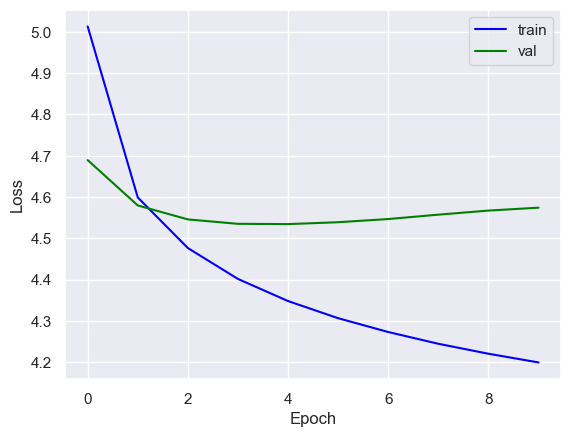

In [49]:
import matplotlib.pyplot as plt
ax = plt.figure().gca()
ax.plot(train_raw_losses, color='blue')
ax.plot(eval_token_losses, color='green')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([
'train', 
'val'
            ])

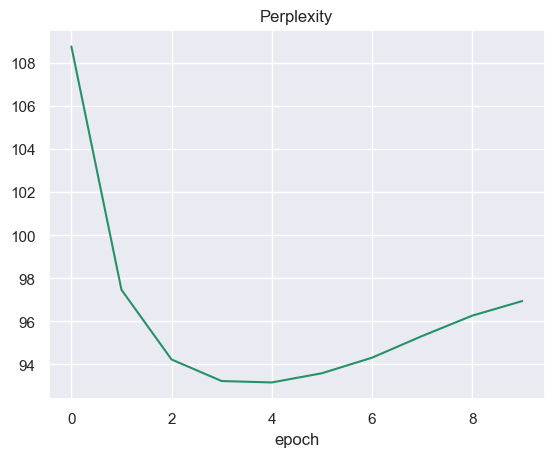

In [50]:
plt.plot(np.arange(len(eval_perplexities)), eval_perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
model = torch.load('model_baseline.pth', weights_only = False) 

In [104]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            # Возвращает логиты для всех позиций
            # [-1] — берём только последний токен, распределение вероятностей для следующего слова
            next_char_distribution = model(input_ids)[-1]
            # слово с максимальной вероятностью
            next_char = next_char_distribution.squeeze().argmax()
            # Добавляем его в конец входа (torch.cat) и продолжаем цикл
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [54]:
generate_sequence(model, starting_seq='i love dicaprio and' )

torch.Size([5])
torch.Size([80004])
tensor(19918, device='cuda:0')
torch.Size([6])


'<bos> i love dicaprio and his friends are all over the top . <eos>'

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [55]:
# Проведите второй эксперимент
# num_layers = 2, LayerNorm, Веса выходной проекции равны весам эмбеддинга, размеры совпадают: [vocab_size, hidden_dim]
class LanguageModel_2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers = 2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.15)
        self.norm = nn.LayerNorm(hidden_dim)

        self.projection.weight = self.embedding.weight

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.norm(output)  # LayerNorm сразу после RNN
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [56]:
model = LanguageModel_2(hidden_dim=256, vocab_size=len(vocab))
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [57]:
model, train_raw_losses, eval_token_losses, eval_perplexities = train_model(model, 10)
torch.save(model, 'model_2.pth') 

Training epoch 9:: 100%|███████████████████████████████████████████████████████████| 6294/6294 [07:05<00:00, 14.80it/s]


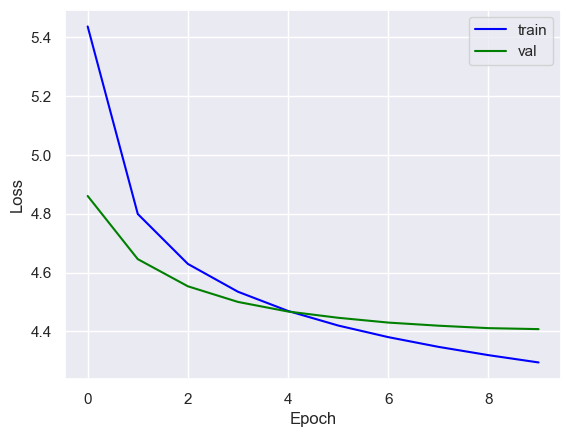

In [58]:
import matplotlib.pyplot as plt
ax = plt.figure().gca()
ax.plot(train_raw_losses, color='blue')
ax.plot(eval_token_losses, color='green')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([
'train', 
'val'
            ])

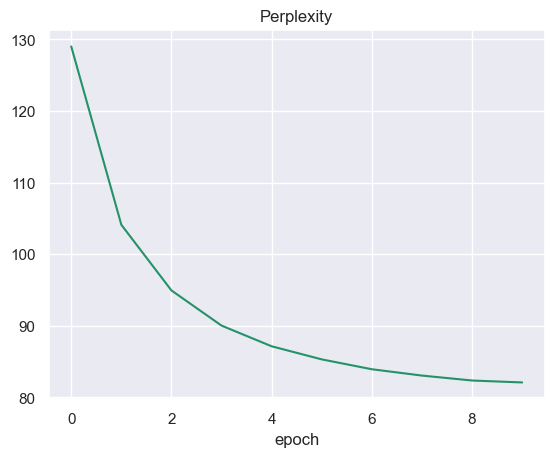

In [59]:
plt.plot(np.arange(len(eval_perplexities)), eval_perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [102]:
model = torch.load('model_2.pth', weights_only = False) 

In [105]:
generate_sequence(model, starting_seq='i love dicaprio and' )

'<bos> i love dicaprio and the <unk> . <eos>'

### Третий эксперимент

In [161]:
import math
# LSTM + Attention
# num_layers = 2, LayerNorm, tie_weights=True
# gradient clipping
class LanguageModel_3_Attn(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, pad_id: int | None = None):
        super().__init__()
        self.pad_id = pad_id
        
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # --- одно-головый self-attention поверх выхода первого RNN ---
        self.q_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.attn_out = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        self.pre_attn_norm  = nn.LayerNorm(hidden_dim)  # нормализация
        self.post_attn_norm = nn.LayerNorm(hidden_dim)
        
         # --- Проецирцющая голова ---
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.15)
        self.norm = nn.LayerNorm(hidden_dim)

        # weight tying
        self.projection.weight = self.embedding.weight

        # место для сохранения
        self.last_attn_weights = None   # [B, T, T]

    def forward(self, input_batch) -> torch.Tensor:
        self.last_attn_weights = None
        
        embeddings = self.embedding(input_batch)     # [B, T, H]
        H1, _ = self.rnn1(embeddings)                  # [B, T, H]

        # ---- causal self-attention над H1----
        H = self.pre_attn_norm(H1) 
        Q = self.q_proj(H)                           # [B, T, H]
        K = self.k_proj(H)                           # [B, T, H]
        V = self.v_proj(H)                           # [B, T, H]

        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / math.sqrt(K.size(-1))  # [B, T, T]
        B, T, _ = attn_scores.shape
        # каузальная маска: запретить смотреть вперёд
        causal_mask = torch.triu(torch.ones(T, T, device=attn_scores.device, dtype=torch.bool), diagonal=1)
        attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))

        # Key-padding mask
        if self.pad_id is not None:
            key_mask = (input_batch == self.pad_id)                 # [B,T]
            attn_scores = attn_scores.masked_fill(key_mask.unsqueeze(1), float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)       # [B, T, T]
        context = torch.matmul(attn_weights, V)                  # [B, T, H]

        # residual + PostNorm
        H_attn = self.post_attn_norm(H1 + self.attn_out(context))        # [B, T, H]

        # ----- Второй RNN слой после внимания -----
        H2, _ = self.rnn2(H_attn)
         # ----- Проецирующая голова -----
        H2 = self.norm(H2)
        H2 = self.dropout(self.linear(self.non_lin(H2)))           # [B, T, H]
        logits = self.projection(self.non_lin(H2))                # [B, T, V]

        self.last_attn_weights = attn_weights.detach()
        
        return logits


In [163]:
model = LanguageModel_3_Attn(hidden_dim=256, vocab_size=len(vocab), pad_id=word2ind['<pad>'])
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch)

In [164]:
model, train_raw_losses, eval_token_losses, eval_perplexities = train_model(model, 10, sched = False, clip = True)
torch.save(model, 'model_3_1.pth')

Training epoch 9:: 100%|███████████████████████████████████████████████████████████| 6294/6294 [07:19<00:00, 14.31it/s]


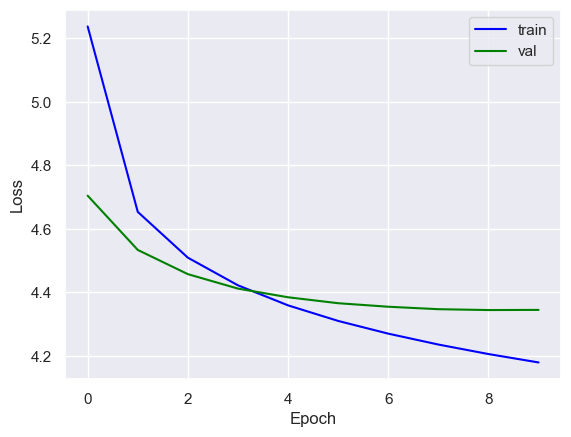

In [165]:
ax = plt.figure().gca()
ax.plot(train_raw_losses, color='blue')
ax.plot(eval_token_losses, color='green')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([
'train', 
'val'
            ])

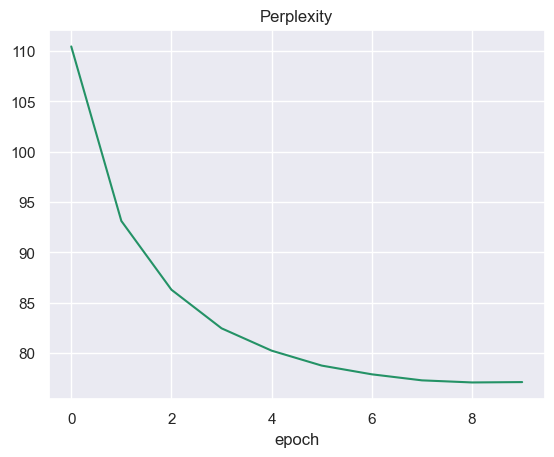

77.04989894244295


In [166]:
plt.plot(np.arange(len(eval_perplexities)), eval_perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()
print(min(eval_perplexities))

In [117]:
model = torch.load('model_3.pth', weights_only = False) 

In [232]:
def generate_sequence_2(model, starting_seq: str, max_seq_len: int = 128, sampling=None) -> str:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    # input_ids = torch.LongTensor(input_ids).to(device)
    # [T] -> [1, T] (batch first!)
    input_ids = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # [1, T]
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            # Возвращает логиты для всех позиций
            # [-1] — берём только последний токен, распределение вероятностей для следующего слова
            logits = model(input_ids)
            next_logits = logits[0, -1, :] # последний по времени для первого (и единственного) в батче
            
            # with sampling
            if sampling == 'Top-K':
                k = min(top_k, next_logits.size(-1))
                vals, idx = torch.topk(next_logits, k)    # top-k логиты и индексы
                filt = torch.full_like(next_logits, float('-inf'))
                filt.scatter_(0, idx, next_logits.index_select(0, idx)) # оставили только top-k  
                probs = torch.softmax(filt, dim=-1)
                next_id = int(torch.multinomial(probs, 1).item())

            elif sampling == 'Top-P':
                sorted_logits, sorted_idx = torch.sort(next_logits, descending=True)
                sorted_probs = torch.softmax(sorted_logits, dim=-1)
                cumprobs = torch.cumsum(sorted_probs, dim=-1)
                keep = cumprobs <= top_p
                keep[..., 0] = True                                      # минимум 1 токен
    
                filt = torch.full_like(next_logits, float('-inf'))
                kept_logits = torch.where(keep, sorted_logits, torch.tensor(float('-inf'), device=logits.device))
                filt.scatter_(0, sorted_idx, kept_logits)                 # вернули в исходный порядок
                probs = torch.softmax(filt, dim=-1)
                next_id = int(torch.multinomial(probs, 1).item())

            elif sampling == None:
                next_id  = int(torch.argmax(next_logits).item())

            # Добавляем его в конец входа (torch.cat) и продолжаем цикл
            next_token = torch.tensor([[next_id]], device=device)  # [1, 1]
            input_ids = torch.cat([input_ids, next_token], dim=1)        # [1, T+1]
            
            if next_id == word2ind['<eos>']:
                break
    ids = input_ids[0].tolist()
    words = ' '.join([ind2word[idx] for idx in ids])

    return words

In [250]:
top_p = 0.9
top_k = 3
generate_sequence_2(model, starting_seq='i love dicaprio and', sampling = 'Top-P')

'<bos> i love dicaprio and sergiu nicolaescu in they were fantastic and very boring . <eos>'

### Attention Matrix

In [180]:
# viz_model = LanguageModel_3_Attn(hidden_dim=256, vocab_size=len(vocab)).to(device)
# viz_model.load_state_dict(model.state_dict())
viz_model = model
viz_model.eval()

with torch.no_grad():
    for batch in eval_dataloader:
        ids = batch['input_ids'].to(device)   # [B, T]
        _ = viz_model(ids)
        attn = viz_model.last_attn_weights    # [B, T, T]
        break
print(attn.shape)

torch.Size([128, 32, 32])


In [177]:
A = attn[b, :L, :L].cpu()
print(A.sum(dim=-1)) 


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [230]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def _sparse_labels(tokens, max_ticks=20):
    L = len(tokens)
    step = max(1, L // max_ticks)
    labels = [''] * L
    for i in range(0, L, step):
        labels[i] = tokens[i]
    return labels

def plot_attn_heatmap_sns(attn: torch.Tensor,
                          input_ids: torch.Tensor,
                          b: int,
                          pad_id: int,
                          ind2word: dict,
                          title: str = "Self-attention (каузальное) поверх RNN",
                          mask_upper: bool = False,
                          cmap: str = "magma"):
    """
    attn: [B, T, T] — веса внимания (после softmax)
    input_ids: [B, T]
    b: индекс примера в батче
    """
    # берём ту же последовательность и матрицу
    seq = input_ids[b]               # [T]
    A   = attn[b]                    # [T, T]

    # отрезаем падды справа
    is_pad = (seq == pad_id)
    if is_pad.any():
        L = int(is_pad.nonzero(as_tuple=False)[0].item())
    else:
        L = int(seq.size(0))
    A = A[:L, :L].detach().cpu().numpy()
    # A = A.detach().cpu().numpy()

    # подписи токенов
    tokens = [ind2word.get(int(t), "<unk>") for t in seq[:L].tolist()]
    xlabels = _sparse_labels(tokens)
    ylabels = _sparse_labels(tokens)

    fig, ax = plt.subplots(figsize=(7, 7))

    hm = sns.heatmap(
        A,
        vmin=0.0, vmax=1.0,
        cmap=cmap,
        square=True,          # аккуратные клетки
        linewidths=0.0,       # никаких линий на границах
        linecolor=None,
        cbar=True,
        cbar_kws={"shrink": 0.9, "aspect": 25, "pad": 0.02},
        xticklabels=xlabels,
        yticklabels=ylabels,
        ax=ax
    )

    # убираем спайны/гриды и наводим красоту
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='x', labelrotation=90, length=0)
    ax.tick_params(axis='y', length=0)

    ax.set_xlabel("key (прошлые и текущие позиции)")
    ax.set_ylabel("query (текущая позиция)")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


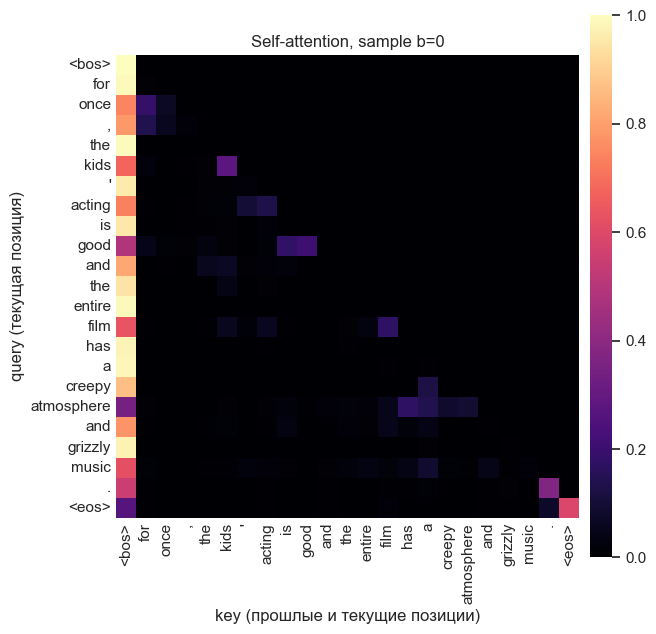

In [231]:
# b = 0
random.randint(0,128)
plot_attn_heatmap_sns(
    attn=attn,   # [B, T, T]
    input_ids=ids,                      # [B, T]
    b=b,
    pad_id=word2ind['<pad>'],
    ind2word=ind2word,
    title=f"Self-attention, sample b={b}",
)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

# Отчет по обучению RNN для генерации текста

## Сравнение экспериментов

  -----------------------------------------------------------------------------------------
       Эксп.      Архитектура / приёмы      Min PPL (val)  Эпоха минимума  Динамика
  --------------- ------------------------ --------------- --------------- ----------------
       **1**      GRU, 1 слой; tanh →            ≈93              4        Сперва падает,
                  Linear → Dropout; без                                    затем растёт
                  нормализаций, раздельные                                 (переподгонка)
                  веса                                                     

       **2**      GRU (2 слоя),                  ≈82             10        Монотонное
                  **LayerNorm**, **weight                                  снижение, к
                  tying**                                                  концу падение
                  (projection=embedding)                                   замедляется

       **3**      LSTM (2 слоя) +                ≈77            8--10      Стабильное
                  **self-attention**,                                      падение, плато к
                  **LayerNorm**,                                           10 эпохе;
                  **gradient clipping**,                                   внимание смещено
                  **weight tying**                                         к BOS
  -----------------------------------------------------------------------------------------

------------------------------------------------------------------------

## Анализ экспериментов

### 1. Базовая модель (GRU, 1 слой)

-   Быстро обучается, но начинает переобучаться после 4-й эпохи.
-   Отсутствие нормализаций и weight tying приводит к росту.
    валидационной перплексии.
-   LR без scheduler усугубляет нестабильность.

### 2. GRU-2 + LayerNorm + Weight Tying

-   Добавление **LayerNorm** стабилизирует градиенты.
-   **Weight tying** уменьшает параметры и улучшает обобщение.
-   Перплексия падает монотонно, что говорит о более устойчивом
    обучении.
-   Требуется scheduler для ускорения сходимости в поздних эпохах.

### 3. LSTM-2 + Self-Attention + Gradient Clipping

-   Самая устойчивая и точная модель.
-   **Gradient clipping** устраняет всплески градиентов.
-   **Self-attention** помогает моделировать долгосрочные зависимости,
    но коллапс внимания к BOS указывает на отсутствие позиционных
    смещений.
-   Если внутри attention нет подсказок о позициях, **softmax может быстро выучить «универсально полезную» точку — BOS**, потому что BOS токен часто       связан со многими словами. Таким образом, attention вырождается в «всегда смотри на BOS».

------------------------------------------------------------------------

## Идеи по улучшению качества

### Внимание и позиционность

-   Добавить **позиционные эмбеддинги**.
-   Использовать **multi-head attention**, чтобы избежать коллапса одной
    головы.
-   Добавить **attn dropout** и **local bias**, чтобы внимание учитывало
    ближний контекст.

### Регуляризация и обучение

-   Применить **scheduler** (cosine decay / OneCycle) с warmup.
-   Использовать **label smoothing** и **weight decay**.
-   Проверить  **dropout** для отдельных слоев (0.1--0.3).


### Данные и токенизация

-   Поменять токенизацию (**BPE / Unigram**).
-   Увеличить контекст обучения (длину последовательности).
